In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/rotten-tomatoes-movies-and-critic-reviews-dataset/rotten_tomatoes_movies.csv
/kaggle/input/rotten-tomatoes-movies-and-critic-reviews-dataset/rotten_tomatoes_critic_reviews.csv


In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv("/kaggle/input/rotten-tomatoes-movies-and-critic-reviews-dataset/rotten_tomatoes_critic_reviews.csv")

In [3]:
df = data[['review_type', 'review_content']][:100]
df.head()

,review_type,review_content
0,Fresh,A fantasy adventure that fuses Greek mythology...
1,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,Fresh,With a top-notch cast and dazzling special eff...
3,Fresh,Whether audiences will get behind The Lightnin...
4,Rotten,What's really lacking in The Lightning Thief i...


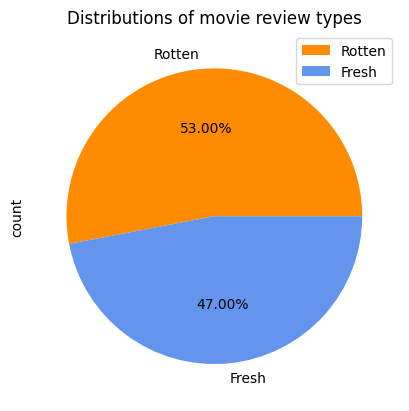

In [4]:
import matplotlib.pyplot as plt
color = ['darkorange', 'cornflowerblue']
df['review_type'].value_counts().plot.pie(colors = color, autopct = "%.2f%%")
plt.title("Distributions of movie review types")
plt.legend()
plt.show()

In [5]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
def preprocess(data):
    exclude = set(string.punctuation)
    rem_punc = ''.join(ch for ch in data if ch not in exclude).lower()
    tokens = word_tokenize(rem_punc)
    return tokens

def stem(tokens):
    stemmed = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(stemmed)

In [6]:
prepro = stem(preprocess(df['review_content'][0]))
print(prepro)

fantasi adventur fuse greek mytholog contemporari american place valu anyon around 15 give take coupl year thrill visual spectacl


In [7]:
li = [type(str(doc)) for doc in df['review_content']]
print(li[0])

<class 'str'>


In [8]:
df['stemmed_and_prepro'] = [stem(preprocess(str(doc))) for doc in df['review_content']]
df['prepro'] = [' '.join(preprocess(str(doc))) for doc in df['review_content']]
df.head()

,review_type,review_content,stemmed_and_prepro,prepro
0,Fresh,A fantasy adventure that fuses Greek mythology...,fantasi adventur fuse greek mytholog contempor...,a fantasy adventure that fuses greek mythology...
1,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",uma thurman medusa gorgon coiffur writh snake ...,uma thurman as medusa the gorgon with a coiffu...
2,Fresh,With a top-notch cast and dazzling special eff...,topnotch cast dazzl special effect tide teen n...,with a topnotch cast and dazzling special effe...
3,Fresh,Whether audiences will get behind The Lightnin...,whether audienc get behind lightn thief hard p...,whether audiences will get behind the lightnin...
4,Rotten,What's really lacking in The Lightning Thief i...,what realli lack lightn thief genuin sens wond...,whats really lacking in the lightning thief is...


In [9]:
from sklearn.model_selection import train_test_split
X1 = df['stemmed_and_prepro']
y1 = df['review_type']
X2 = df['prepro']
y2 = y1

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
X1_train.shape, X2_train.shape,X1_test.shape, X2_test.shape

((80,), (80,), (20,), (20,))

In [10]:
tfidf_vectorizer1 = TfidfVectorizer()
tfidf_matrix_model1 = tfidf_vectorizer1.fit_transform(X1_train)
X_test_model1 = tfidf_vectorizer1.transform(X1_test)

tfidf_vectorizer2 = TfidfVectorizer()
tfidf_matrix_model2 = tfidf_vectorizer2.fit_transform(X2_train)
X_test_model2 = tfidf_vectorizer2.transform(X2_test)
tfidf_matrix_model1.shape, tfidf_matrix_model2.shape, X_test_model1.shape, X_test_model2.shape

((80, 627), (80, 771), (20, 627), (20, 771))

In [11]:
type(np.array(y1_train))

numpy.ndarray

In [12]:
def classify(X_train_matrix, X_test_vector, y_train):
    cosine_similarities = cosine_similarity(X_train_matrix, X_test_vector)
    most_similar_doc_index = np.argmax(cosine_similarities, axis=0)
    return np.array(y_train)[most_similar_doc_index[0]]

In [13]:
predictions_model1 = [classify(tfidf_matrix_model1, X_test_model1[i], y1_train) for i in range(X_test_model1.shape[0])]
predictions_model2 = [classify(tfidf_matrix_model2, X_test_model2[i], y2_train) for i in range(X_test_model2.shape[0])]

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label="Fresh")
    recall = recall_score(y_true, y_pred, pos_label="Fresh")
    f1 = f1_score(y_true, y_pred, pos_label="Fresh")
    return accuracy, precision, recall, f1

In [15]:
accuracy_model1, precision_model1, recall_model1, f1_model1 = evaluate(y1_test, predictions_model1)

# Evaluate Model 2
accuracy_model2, precision_model2, recall_model2, f1_model2 = evaluate(y2_test, predictions_model2)

# Step 8: Print Results
print("Model 1 (With Stopword Removal & Stemming):")
print(f"Accuracy: {accuracy_model1:.2f}")
print(f"Precision: {precision_model1:.2f}")
print(f"Recall: {recall_model1:.2f}")
print(f"F1 Score: {f1_model1:.2f}")

print("\nModel 2 (Without Stopword Removal & Stemming):")
print(f"Accuracy: {accuracy_model2:.2f}")
print(f"Precision: {precision_model2:.2f}")
print(f"Recall: {recall_model2:.2f}")
print(f"F1 Score: {f1_model2:.2f}")

Model 1 (With Stopword Removal & Stemming):
Accuracy: 0.55
Precision: 0.45
Recall: 0.62
F1 Score: 0.53

Model 2 (Without Stopword Removal & Stemming):
Accuracy: 0.55
Precision: 0.45
Recall: 0.62
F1 Score: 0.53
